# Airbnb Data Analysis and Price Prediction 
## Price Prediction Part

### Team Members
* Bike Sönmez, sonmezb19@itu.edu.tr, 090190326
* Berfin Duman , dumanb19@itu.edu.tr, 040190108

**Neccesary Libraries** 

In [6]:
import pandas as pd
import numpy as np

#Sklearn Libraries: 
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV,GridSearchCV,StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso 
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier,GradientBoostingRegressor, RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.decomposition import PCA
import scipy.cluster.hierarchy as sch

from yellowbrick.model_selection import ValidationCurve, FeatureImportances
from yellowbrick.cluster import KElbowVisualizer
# Visualization 
import seaborn as sns
import matplotlib.pyplot as plt

#Throws warning
import warnings
warnings.filterwarnings("ignore")

---

**Importing Dataset**

In [7]:
df = pd.read_csv("../datasets/AB_NYC_2019.csv") 
df.head() #return first 5 rows in dataset:

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [8]:
print(df.shape) #returns first 5 rows in dataset 
print(df.id.nunique()) #returns number of unique values in id column
print(df.columns ) #returns column names

(48895, 16)
48895
Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object')


In this notebook, we explore different models for price prediction. When we look at our dataset, let's start by discarding some columns that are unnecessary for our model: \
**Id column** assigns a unique ID to each data point. Including this column in our model will not add any information when making price predictions, so we will exclude this feature from our data series. \
Likewise, since the **host_name, host_id, name, last_review** properties do not produce any meaningful information, we will not add them to our model.

In [9]:
df.drop(['id','host_name','host_id','last_review','name'], axis=1, inplace=True) 
df.head() #return first 5 rows in our new dataset:

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,1,365
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0


In [10]:
df.drop_duplicates(inplace=True) #removes if any duplicate lines.

In [11]:
df.isnull().sum() #returns the total number of missing values in each column.

neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

As you can see, we have null values in our dataset. We need to deal with these values before we add them to our model.



In [12]:
df.describe().round(2) #returns provide statistical summary of dataset

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,48895.00,48895.00,48895.00,48895.00,48895.00,38843.00,48895.00,48895.00
mean,40.73,-73.95,152.72,7.03,23.27,1.37,7.14,112.78
std,0.05,0.05,240.15,20.51,44.55,1.68,32.95,131.62
min,40.50,-74.24,0.00,1.00,0.00,0.01,1.00,0.00
25%,40.69,-73.98,69.00,1.00,1.00,0.19,1.00,0.00
50%,40.72,-73.96,106.00,3.00,5.00,0.72,1.00,45.00
75%,40.76,-73.94,175.00,5.00,24.00,2.02,2.00,227.00
max,40.91,-73.71,10000.00,1250.00,629.00,58.50,327.00,365.00


Also you can see, different features have values in very different ranges in the dataset, so we will balance the differences by scaling the features.

In [13]:
df.info() #returns general information of dataset like column names, non-null count and dtype infos. 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48895 entries, 0 to 48894
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   neighbourhood_group             48895 non-null  object 
 1   neighbourhood                   48895 non-null  object 
 2   latitude                        48895 non-null  float64
 3   longitude                       48895 non-null  float64
 4   room_type                       48895 non-null  object 
 5   price                           48895 non-null  int64  
 6   minimum_nights                  48895 non-null  int64  
 7   number_of_reviews               48895 non-null  int64  
 8   reviews_per_month               38843 non-null  float64
 9   calculated_host_listings_count  48895 non-null  int64  
 10  availability_365                48895 non-null  int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 4.5+ MB


In [14]:
df.nunique() #returns number of unique values in each column

neighbourhood_group                   5
neighbourhood                       221
latitude                          19048
longitude                         14718
room_type                             3
price                               674
minimum_nights                      109
number_of_reviews                   394
reviews_per_month                   937
calculated_host_listings_count       47
availability_365                    366
dtype: int64

In [15]:
df.neighbourhood.unique()

array(['Kensington', 'Midtown', 'Harlem', 'Clinton Hill', 'East Harlem',
       'Murray Hill', 'Bedford-Stuyvesant', "Hell's Kitchen",
       'Upper West Side', 'Chinatown', 'South Slope', 'West Village',
       'Williamsburg', 'Fort Greene', 'Chelsea', 'Crown Heights',
       'Park Slope', 'Windsor Terrace', 'Inwood', 'East Village',
       'Greenpoint', 'Bushwick', 'Flatbush', 'Lower East Side',
       'Prospect-Lefferts Gardens', 'Long Island City', 'Kips Bay',
       'SoHo', 'Upper East Side', 'Prospect Heights',
       'Washington Heights', 'Woodside', 'Brooklyn Heights',
       'Carroll Gardens', 'Gowanus', 'Flatlands', 'Cobble Hill',
       'Flushing', 'Boerum Hill', 'Sunnyside', 'DUMBO', 'St. George',
       'Highbridge', 'Financial District', 'Ridgewood',
       'Morningside Heights', 'Jamaica', 'Middle Village', 'NoHo',
       'Ditmars Steinway', 'Flatiron District', 'Roosevelt Island',
       'Greenwich Village', 'Little Italy', 'East Flatbush',
       'Tompkinsville', 'Asto

In [16]:
df.neighbourhood_group.unique()

array(['Brooklyn', 'Manhattan', 'Queens', 'Staten Island', 'Bronx'],
      dtype=object)

In [17]:
df.room_type.unique()

array(['Private room', 'Entire home/apt', 'Shared room'], dtype=object)

As you can see, there are 3 object type properties in our dataset. When we examine this data, we observe that we need to encode the data. Since there is no meaning between the data, we will do **OneHotEncoding** in all encoding operations.

---

In summary, we can say that before adding our dataset to the model for price estimation, there are some steps we need to do as we mentioned above;
1. fill in the blank values,
2. scaling the data
3. encode categorical values\


We will create a pipeline and perform all the steps in one step.

---
But first, let's separate our dataset as X, y and then train test. 

In [18]:
X = df.drop(columns=['price'], axis=1)  # independent variables 
y = df['price'] # target variable

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1773)  # split 20:80 

In [20]:
print(" Size of train data", X_train.shape)
print(" Size of train data", y_train.shape)
print(" Size of test data", X_test.shape)
print(" Size of test data", y_test.shape)

 Size of train data (39116, 10)
 Size of train data (39116,)
 Size of test data (9779, 10)
 Size of test data (9779,)


Let's list the numeric and categorical values in our data for convenience. We will use these lists later:

In [21]:
numeric_cols = []
categorical_cols = []
for column in X_train.columns:
    if X_train[column].dtype in ['int64', 'float64']:
        numeric_cols.append(column)
    else:
        categorical_cols.append(column)
print("Numeric columns:")
print(numeric_cols)
print("\nCategoric columns:")
print(categorical_cols)

Numeric columns:
['latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']

Categoric columns:
['neighbourhood_group', 'neighbourhood', 'room_type']


In [22]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn import set_config
set_config(transform_output="pandas") 
# Identification of converters
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(drop= "first", handle_unknown='ignore', sparse=False))
])

# Creating the ColumnTransformer
ct = ColumnTransformer(transformers=[
    ('numeric', numeric_transformer, numeric_cols),
    ('categorical', categorical_transformer, categorical_cols)
])

# Fit and transform the training data
X_train_transformed = ct.fit_transform(X_train)
# Transform the test data
X_test_transformed = ct.transform(X_test)
print("After ColumnTransformer, column names our dataset ",X_train_transformed.columns )

# Get feature names from column transformer
numeric_feature_names = numeric_cols
categorical_feature_names = ct.transformers_[1][1]['encoder'].get_feature_names_out(['neighbourhood_group', 'neighbourhood', 'room_type'])
feature_names = numeric_feature_names + list(categorical_feature_names)

# Convert transformed data to DataFrame and column names
X_train_transformed = pd.DataFrame(X_train_transformed)
X_test_transformed = pd.DataFrame(X_test_transformed)
X_train_transformed.columns=feature_names
X_test_transformed.columns=feature_names
print("Feature names we prefer: ",X_train_transformed.columns )

After ColumnTransformer, column names our dataset  Index(['numeric__latitude', 'numeric__longitude', 'numeric__minimum_nights',
       'numeric__number_of_reviews', 'numeric__reviews_per_month',
       'numeric__calculated_host_listings_count', 'numeric__availability_365',
       'categorical__neighbourhood_group_Brooklyn',
       'categorical__neighbourhood_group_Manhattan',
       'categorical__neighbourhood_group_Queens',
       ...
       'categorical__neighbourhood_Williamsbridge',
       'categorical__neighbourhood_Williamsburg',
       'categorical__neighbourhood_Willowbrook',
       'categorical__neighbourhood_Windsor Terrace',
       'categorical__neighbourhood_Woodhaven',
       'categorical__neighbourhood_Woodlawn',
       'categorical__neighbourhood_Woodrow',
       'categorical__neighbourhood_Woodside',
       'categorical__room_type_Private room',
       'categorical__room_type_Shared room'],
      dtype='object', length=231)
Feature names we prefer:  Index(['latitude', '

In [20]:
X_train_transformed.head()

,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,...,neighbourhood_Williamsbridge,neighbourhood_Williamsburg,neighbourhood_Willowbrook,neighbourhood_Windsor Terrace,neighbourhood_Woodhaven,neighbourhood_Woodlawn,neighbourhood_Woodrow,neighbourhood_Woodside,room_type_Private room,room_type_Shared room
5714,1.005976,-0.557186,-0.157660,-0.365699,-0.837354,-0.156983,-0.856544,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
14157,-1.249946,-0.204818,-0.316517,-0.522672,0.000000,-0.187282,-0.856544,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3173,-0.815890,-0.090250,-0.263565,-0.388124,-0.837354,-0.187282,-0.856544,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
14196,2.802223,0.947578,-0.210612,-0.500247,-0.870563,-0.187282,1.506329,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6094,-0.581111,0.068066,-0.316517,-0.432973,-0.870563,-0.096385,0.397070,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
X_test_transformed.describe()

,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,...,neighbourhood_Williamsbridge,neighbourhood_Williamsburg,neighbourhood_Willowbrook,neighbourhood_Windsor Terrace,neighbourhood_Woodhaven,neighbourhood_Woodlawn,neighbourhood_Woodrow,neighbourhood_Woodside,room_type_Private room,room_type_Shared room
count,9779.000000,9779.000000,9779.000000,9779.000000,9779.000000,9779.000000,9779.000000,9779.000000,9779.000000,9779.000000,...,9779.000000,9779.000000,9779.0,9779.000000,9779.000000,9779.000000,9779.0,9779.000000,9779.000000,9779.000000
mean,-0.005239,0.005765,0.013916,-0.003746,-0.019897,-0.005627,0.001651,0.414971,0.440025,0.116883,...,0.000716,0.075468,0.0,0.002863,0.001125,0.000307,0.0,0.003988,0.453421,0.023724
std,0.989219,0.998186,1.377596,0.995151,0.973410,0.992105,1.000107,0.492742,0.496415,0.321297,...,0.026747,0.264158,0.0,0.053436,0.033522,0.017513,0.0,0.063029,0.497851,0.152197
min,-4.073326,-6.028740,-0.316517,-0.522672,-0.910413,-0.187282,-0.856544,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
25%,-0.723113,-0.674786,-0.316517,-0.500247,-0.737730,-0.187282,-0.856544,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
50%,-0.111737,-0.071408,-0.210612,-0.410549,-0.153265,-0.187282,-0.522247,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
75%,0.611355,0.351455,-0.104708,0.015521,0.092476,-0.156983,0.845332,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,1.000000,0.000000
max,3.263363,5.096508,65.820876,12.797597,10.918358,9.690194,1.916602,1.000000,1.000000,1.000000,...,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000


## PRICE PREDICTION (REGRESSION ANALYSIS)
---
In the regression analysis, our results were not very good, so we approached experimentally and gave the model different features and proceeded according to the results.

We applied log transformation to target values. The log transform improves the performance of the linear regression model, providing better fit and predictive ability. Throughout our regression analysis, we will proceed through alternating target values.

In [22]:
y_train_log = np.log(y_train+1)
y_test_log= np.log(y_test+1)

### R2 Score of Linear Regression Model With All Numeric Features In Dataset
First, let's train the model only on numeric values, without the values we encoded.

Latitude and longitude values are spatial features, it does not make much sense to use them in regression analysis, but we still wanted to look at the result by giving our entire dataset to the model first.

In [23]:
#Only numeric values +spatial values (long, lat)
model_all_data=LinearRegression()
model_all_data.fit(X_train_transformed[numeric_cols],y_train_log)
print("Using LinearRegression Model with only numeric values +spatial values (long, lat) in dataset:")
print("r2 Score of Train Data: ",model_all_data.score(X_train_transformed[numeric_cols], y_train_log))
print("r2 Score of Test Data: ", model_all_data.score(X_test_transformed[numeric_cols], y_test_log))


Using LinearRegression Model with only numeric values +spatial values (long, lat) in dataset:
r2 Score of Train Data:  0.1382968676459192
r2 Score of Test Data:  0.14391302141722606


In [24]:
X_train_transformed[numeric_cols[2:]].head(2)

,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
5714,-0.157660,-0.365699,-0.837354,-0.156983,-0.856544
14157,-0.316517,-0.522672,0.000000,-0.187282,-0.856544


### We have extracted the lat and long values as it should be

In [25]:
#Only numeric values 
model_all_data=LinearRegression()

model_all_data.fit(X_train_transformed[numeric_cols[2:]],y_train_log )
print("Using LinearRegression Model with only numeric values in dataset:")
print("r2 Score of Train Data: ",model_all_data.score( X_train_transformed[numeric_cols[2:]], y_train_log ))
print("r2 Score of Test Data: ",model_all_data.score( X_test_transformed[numeric_cols[2:]], y_test_log))


Using LinearRegression Model with only numeric values in dataset:
r2 Score of Train Data:  0.02495729723566431
r2 Score of Test Data:  0.026557178534081127


### With all numeric and all categorical values (extracted the lat and long values) 

In [26]:
#All Features
model_all_data=LinearRegression()

model_all_data.fit(X_train_transformed[X_train_transformed.columns[2:]],y_train_log )
print("Using LinearRegression Model with numeric+ all categorical values in dataset:")
print("r2 Score of Train Data: ",model_all_data.score( X_train_transformed[X_train_transformed.columns[2:]], y_train_log ))
print("r2 Score of Test Data: ",model_all_data.score( X_test_transformed[X_train_transformed.columns[2:]], y_test_log))


Using LinearRegression Model with numeric+ all categorical values in dataset:
r2 Score of Train Data:  0.5378631690439367
r2 Score of Test Data:  -5.163844236470695e+16


After the Neighborhood feature was encoded, our model started to give very bad results because it turned our dataset into a very sparse matrix, and we proceeded by removing this result from the encoding part.

In [23]:
X_train_comb=X_train_transformed[X_train_transformed.columns[np.r_[2:11, 229:231]]] #new X_train which we used price prediction models
X_test_comb=X_test_transformed[X_test_transformed.columns[np.r_[2:11, 229:231]]] #new X_test which we used price prediction models
X_train_comb.head()

,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,room_type_Private room,room_type_Shared room
5714,-0.157660,-0.365699,-0.837354,-0.156983,-0.856544,0.0,1.0,0.0,0.0,1.0,0.0
14157,-0.316517,-0.522672,0.000000,-0.187282,-0.856544,1.0,0.0,0.0,0.0,1.0,0.0
3173,-0.263565,-0.388124,-0.837354,-0.187282,-0.856544,1.0,0.0,0.0,0.0,1.0,0.0
14196,-0.210612,-0.500247,-0.870563,-0.187282,1.506329,0.0,0.0,0.0,0.0,0.0,0.0
6094,-0.316517,-0.432973,-0.870563,-0.096385,0.397070,1.0,0.0,0.0,0.0,0.0,0.0


The encoded form of the neighborhood_group, room_type and numeric values properties creates the train and test data.

### The most optimal r2 score is obtained with the linear regression model.


In [28]:
model_all_data=LinearRegression()
model_all_data.fit(X_train_comb,y_train_log)
print("Bes tOptimal Score \nUsing LinearRegression Model with numeric+ just two categorical values (neighborhood_group and room_type) in dataset:")
print("r2 Score of Train Data: ",model_all_data.score( X_train_comb, y_train_log))
print("r2 Score of Train Data: ",model_all_data.score( X_test_comb, y_test_log))

Bes tOptimal Score 
Using LinearRegression Model with numeric+ just two categorical values (neighborhood_group and room_type) in dataset:
r2 Score of Train Data:  0.46748116525718353
r2 Score of Train Data:  0.47433085686336784


Let's try to improve our results by trying different regression models with the features we get the best results from!

In [29]:
#create the indices for 3-fold cv
kcv_index = KFold(n_splits=3, shuffle=True, random_state=1773)

### Ridge

Ridge Regression is a regularization technique used in linear regression to mitigate overfitting by adding a regularization term to the cost function.
It helps control the complexity of the model by shrinking the coefficients, preventing them from becoming too large and reducing the impact of irrelevant features.

In [30]:
model_all_data=Ridge()
model_all_data.fit(X_train_comb,y_train_log)
print("Ridge Regression models:")
print("r2 Score of Train Data: ",model_all_data.score( X_train_comb, y_train_log))
print("r2 Score of Train Data: ",model_all_data.score( X_test_comb, y_test_log))

Ridge Regression models:
r2 Score of Train Data:  0.4674810204063822
r2 Score of Train Data:  0.47434109603176333


**Hyperparameter Tuning**

In [32]:
#create your ridge estimator chained with standardscaler
ridge_pipe = make_pipeline( Ridge()) 

#create a vector of possible values for lambda
param_grid = {'ridge__alpha' : np.linspace(0.01, 5, 50)} #estimator name-double underscore-hyperparameter name
    
#instantiate GridSearchCV with ridge_pipe
grid_search = GridSearchCV(estimator = ridge_pipe, param_grid = param_grid, scoring='r2', cv=kcv_index, return_train_score=True) 
grid_search.fit(X_train_comb, y_train_log)


GridSearchCV(cv=KFold(n_splits=3, random_state=1773, shuffle=True),
             estimator=Pipeline(steps=[('ridge', Ridge())]),
             param_grid={'ridge__alpha': array([0.01      , 0.11183673, 0.21367347, 0.3155102 , 0.41734694,
       0.51918367, 0.62102041, 0.72285714, 0.82469388, 0.92653061,
       1.02836735, 1.13020408, 1.23204082, 1.33387755, 1.43571429,
       1.53755102, 1.63938776, 1.74122449, 1.84306122, 1.9...
       2.04673469, 2.14857143, 2.25040816, 2.3522449 , 2.45408163,
       2.55591837, 2.6577551 , 2.75959184, 2.86142857, 2.96326531,
       3.06510204, 3.16693878, 3.26877551, 3.37061224, 3.47244898,
       3.57428571, 3.67612245, 3.77795918, 3.87979592, 3.98163265,
       4.08346939, 4.18530612, 4.28714286, 4.38897959, 4.49081633,
       4.59265306, 4.6944898 , 4.79632653, 4.89816327, 5.        ])},
             return_train_score=True, scoring='r2')

In [35]:
print("Hyperparameter Tunning of Ridge Regression models:")
print("r2 Score of Train Data: ",grid_search.score( X_train_comb, y_train_log))
print("r2 Score of Train Data: ",grid_search.score( X_test_comb, y_test_log))

Hyperparameter Tunning of Ridge Regression models:
r2 Score of Train Data:  0.4674805001898875
r2 Score of Train Data:  0.4743524566117967


### Lasso
Lasso Regression is a regularization technique used in linear regression models. Lasso uses the L1 regularity term to zero redundant features, thus providing a natural feature selection.Lasso is used as an efficient method for feature selection and model interpretability in high-dimensional datasets.

In [37]:
model_all_data=Lasso()
model_all_data.fit(X_train_comb,y_train_log)
print("Lasso Regression models:")
print("r2 Score of Train Data: ",model_all_data.score( X_train_comb, y_train_log))
print("r2 Score of Train Data: ",model_all_data.score( X_test_comb, y_test_log))

Lasso Regression models:
r2 Score of Train Data:  0.0
r2 Score of Train Data:  -0.0001333709283768414


In [38]:
#create your ridge estimator chained with standardscaler
lasso_pipe = make_pipeline( Lasso()) 

#create a vector of possible values for lambda #0.01, 6, 50
param_grid = {'lasso__alpha' : np.linspace(0.0001,0.5,100)} #estimator name-double underscore-hyperparameter name

    
#instantiate GridSearchCV with ridge_pipe
gs_lasso = GridSearchCV(estimator = lasso_pipe, param_grid = param_grid, scoring='r2', cv=kcv_index, return_train_score=True) 
gs_lasso.fit(X_train_comb, y_train_log)

GridSearchCV(cv=KFold(n_splits=3, random_state=1773, shuffle=True),
             estimator=Pipeline(steps=[('lasso', Lasso())]),
             param_grid={'lasso__alpha': array([1.00000000e-04, 5.14949495e-03, 1.01989899e-02, 1.52484848e-02,
       2.02979798e-02, 2.53474747e-02, 3.03969697e-02, 3.54464646e-02,
       4.04959596e-02, 4.55454545e-02, 5.05949495e-02, 5.56444444e-02,
       6.06939394e-02, 6.57434343...
       3.83861616e-01, 3.88911111e-01, 3.93960606e-01, 3.99010101e-01,
       4.04059596e-01, 4.09109091e-01, 4.14158586e-01, 4.19208081e-01,
       4.24257576e-01, 4.29307071e-01, 4.34356566e-01, 4.39406061e-01,
       4.44455556e-01, 4.49505051e-01, 4.54554545e-01, 4.59604040e-01,
       4.64653535e-01, 4.69703030e-01, 4.74752525e-01, 4.79802020e-01,
       4.84851515e-01, 4.89901010e-01, 4.94950505e-01, 5.00000000e-01])},
             return_train_score=True, scoring='r2')

In [40]:
gs_lasso.best_params_

{'lasso__alpha': 0.0001}

In [39]:
print("Hyperparameter Tunning of Lasso Regression models:")
print("r2 Score of Train Data: ", gs_lasso.score(X_train_comb, y_train_log))
print("r2 Score of Train Data: ", gs_lasso.score(X_test_comb, y_test_log))

Hyperparameter Tunning of Lasso Regression models:
r2 Score of Train Data:  0.46747126258860083
r2 Score of Train Data:  0.4743892080984178


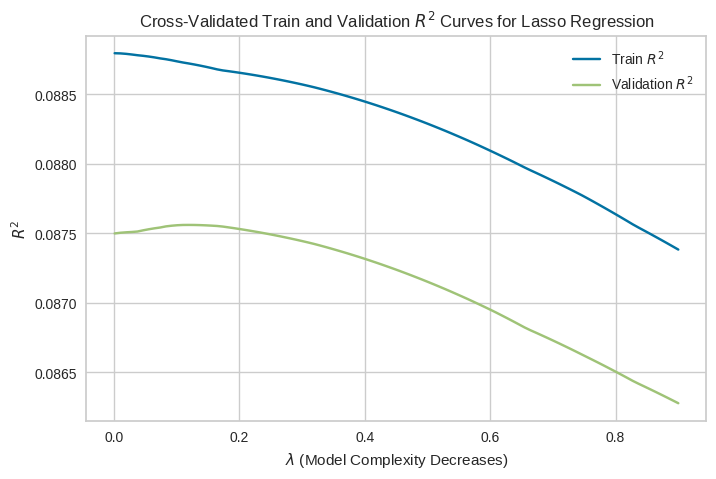

In [41]:
from sklearn.model_selection import validation_curve

fig, ax = plt.subplots(figsize=(8, 5))
# create your ridge estimator
lasso_pipe = make_pipeline(Lasso()) 

# generate the validation curve using validation_curve function
train_scores, valid_scores = validation_curve(lasso_pipe, X_train_comb, y_train, 
                                              param_name='lasso__alpha', 
                                              param_range=list(np.linspace(0.001, 0.9, 100)), 
                                              cv=kcv_index, scoring="r2")

# plot the cross-validated train and validation scores
ax.plot(np.linspace(0.001, 0.9, 100), np.mean(train_scores, axis=1), label="Train $R^2$")
ax.plot(np.linspace(0.001, 0.9, 100), np.mean(valid_scores, axis=1), label="Validation $R^2$")
ax.set_title("Cross-Validated Train and Validation $R^2$ Curves for Lasso Regression")
ax.set_ylabel("$R^2$")
ax.set_xlabel('$\lambda$ (Model Complexity Decreases)')
ax.legend().set_visible(True)
plt.show()


### Decision Tree Regressor


In [42]:
d_tree = DecisionTreeRegressor(max_depth=4, random_state=1454)
d_tree.fit(X_train_comb, y_train_log)
print("Decision Tree Regression models:")
print("r2 Score of Train Data: ",d_tree.score( X_train_comb, y_train_log))
print("r2 Score of Train Data: ",d_tree.score( X_test_comb, y_test_log))

Decision Tree Regression models:
r2 Score of Train Data:  0.47105463701521555
r2 Score of Train Data:  0.4818673777205479


In [43]:
#multiple hyper-parameter tuning with RandomizedSearchCV

tree = DecisionTreeRegressor(random_state=1773)

#defining parameter range
param_grid = {'max_depth': list(range(1, 9)),
              'max_leaf_nodes': [2, 3, 4, 5, 6, 7,None],
              'min_samples_split': list(range(2,8)),
               'min_samples_leaf': list(range(4, 8)),
              }

#The folds are made by preserving the percentage of samples for each class.
cv_index = KFold(n_splits=5, shuffle=True, random_state=1773) 

rd_search = RandomizedSearchCV(estimator = tree, 
                               param_distributions = param_grid,  #only this argument name is different
                               scoring='r2', 
                               cv = cv_index,
                               random_state=1773) #randomized
rd_search.fit(X_train_comb, y_train_log)


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=1773, shuffle=True),
                   estimator=DecisionTreeRegressor(random_state=1773),
                   param_distributions={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8],
                                        'max_leaf_nodes': [2, 3, 4, 5, 6, 7,
                                                           None],
                                        'min_samples_leaf': [4, 5, 6, 7],
                                        'min_samples_split': [2, 3, 4, 5, 6,
                                                              7]},
                   random_state=1773, scoring='r2')

In [44]:
print("Hyperparameter Tunning of Decision Tree Regression models:")
print("r2 Score of Train Data:  %.4f " % rd_search.score(X_train_comb, y_train_log))
print("r2 Score of Train Data:  %.4f " % (rd_search.score(X_test_comb, y_test_log)))

Hyperparameter Tunning of Decision Tree Regression models:
r2 Score of Train Data:  0.4497 
r2 Score of Train Data:  0.4582 


### Random Forest Regressor

In [45]:
rf_reg= RandomForestRegressor( max_depth=4, random_state=1773)
rf_reg.fit(X_train_comb, y_train_log)
print("Random Forest Regression models:")
print("r2 Score of Train Data: ",rf_reg.score( X_train_comb, y_train_log))
print("r2 Score of Train Data: ",rf_reg.score( X_test_comb, y_test_log))

Random Forest Regression models:
r2 Score of Train Data:  0.4754614752552815
r2 Score of Train Data:  0.48624914383602824


In [ ]:
#multiple hyper-parameter tuning with RandomizedSearchCV
rf = RandomForestRegressor(random_state=1773) 

#defining parameter range
param_grid = {'max_depth': list(range(1, 9)),
              'max_leaf_nodes': [2, 3, 4, 5, 6, 7,None],
              'min_samples_split': list(range(2,8)),
               'min_samples_leaf': list(range(4, 8)),
              }

#The folds are made by preserving the percentage of samples for each class.
cv_index = KFold(n_splits=5, shuffle=True, random_state=1773) 

rd_search = RandomizedSearchCV(estimator = rf, 
                               param_distributions = param_grid,  #only this argument name is different
                               scoring='r2', 
                               cv = cv_index,
                               random_state=1773) #randomized

In [ ]:
rd_search.fit(X_train_comb.to_numpy(), y_train)


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=1773, shuffle=True),
                   estimator=RandomForestRegressor(random_state=1773),
                   param_distributions={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8],
                                        'max_leaf_nodes': [2, 3, 4, 5, 6, 7,
                                                           None],
                                        'min_samples_leaf': [4, 5, 6, 7],
                                        'min_samples_split': [2, 3, 4, 5, 6,
                                                              7]},
                   random_state=1773, scoring='r2')

In [ ]:
print("Hyperparameter Tunning of Random Forest Regression models:")
print("r2 Score of Train Data:  %.4f "  % rd_search.score(X_train_comb, y_train))
print("r2 Score of Test Data:  %.4f " % rd_search.score(X_test_comb, y_test))

r2 Score of Train Data:  0.1122 
r2 Score of Test Data:  0.1026 


Gradient Boosting Regressor

In [47]:
reg = GradientBoostingRegressor(random_state=1773)
reg.fit(X_train_comb, y_train_log)
GradientBoostingRegressor(random_state=0)
print("Gradient Boosting Regression models:")
print("r2 Score of Train Data:  %.4f "  % reg.score(X_train_comb, y_train_log))
print("r2 Score of Test Data:  %.4f " % reg.score(X_test_comb, y_test_log))

Gradient Boosting Regression models:
r2 Score of Train Data:  0.5227 
r2 Score of Test Data:  0.5334 


In [ ]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [3, 5, 7]
}

# Instantiate the Gradient Boosting Regressor
reg = GradientBoostingRegressor(random_state=1773)

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=reg, param_grid=param_grid, scoring='r2', cv=cv_index)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train_comb, y_train_log)

# Get the best estimator from GridSearchCV
best_reg = grid_search.best_estimator_

In [ ]:
grid_search.best_params_

{'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100}

In [ ]:
# Print the best scores
print("Hyperparameter Tunning of Gradient Boosting Regression models:")
print("Best R^2 Score of Train Data: ", grid_search.best_score_)
print("Best R^2 Score of Test Data: ", best_reg.score(X_test_comb, y_test_log))

Best R^2 Score of Train Data:  0.5266725505845173
Best R^2 Score of Test Data:  0.5556042788142574


## Classification

In [ ]:
X_train_comb.head()

,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,room_type_Private room,room_type_Shared room
5714,-0.157660,-0.365699,-0.837354,-0.156983,-0.856544,0.0,1.0,0.0,0.0,1.0,0.0
14157,-0.316517,-0.522672,0.000000,-0.187282,-0.856544,1.0,0.0,0.0,0.0,1.0,0.0
3173,-0.263565,-0.388124,-0.837354,-0.187282,-0.856544,1.0,0.0,0.0,0.0,1.0,0.0
14196,-0.210612,-0.500247,-0.870563,-0.187282,1.506329,0.0,0.0,0.0,0.0,0.0,0.0
6094,-0.316517,-0.432973,-0.870563,-0.096385,0.397070,1.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
y_train.values

array([119,  60,  50, ...,  35, 200,  10])

In [49]:
y_train_clsf=y_train.copy()
y_test_clsf=y_test.copy()

In [50]:
category_1 = (y_train_clsf.describe().loc["min"], y_train_clsf.describe().loc["25%"])
category_2 = (y_train_clsf.describe().loc["25%"], y_train_clsf.describe().loc["50%"])
category_3 = (y_train_clsf.describe().loc["50%"], y_train_clsf.describe().loc["75%"])
category_4 = (y_train_clsf.describe().loc["75%"], y_train_clsf.describe().loc["max"])

y_train_clsf.loc[y_train_clsf.between(category_1[0], category_1[1])] = 0
y_train_clsf.loc[y_train_clsf.between(category_2[0], category_2[1])] = 1
y_train_clsf.loc[y_train_clsf.between(category_3[0], category_3[1])] = 2
y_train_clsf.loc[y_train_clsf.between(category_4[0], category_4[1])]= 3

In [51]:
y_test_clsf.loc[y_test_clsf.between(category_1[0], category_1[1])] = 0
y_test_clsf.loc[y_test_clsf.between(category_2[0], category_2[1])] = 1
y_test_clsf.loc[y_test_clsf.between(  category_3[0], category_3[1])] = 2
y_test_clsf.loc[y_test_clsf.between(category_4[0], category_4[1])]= 3

**After re-created target value for classification, map view of classes:**

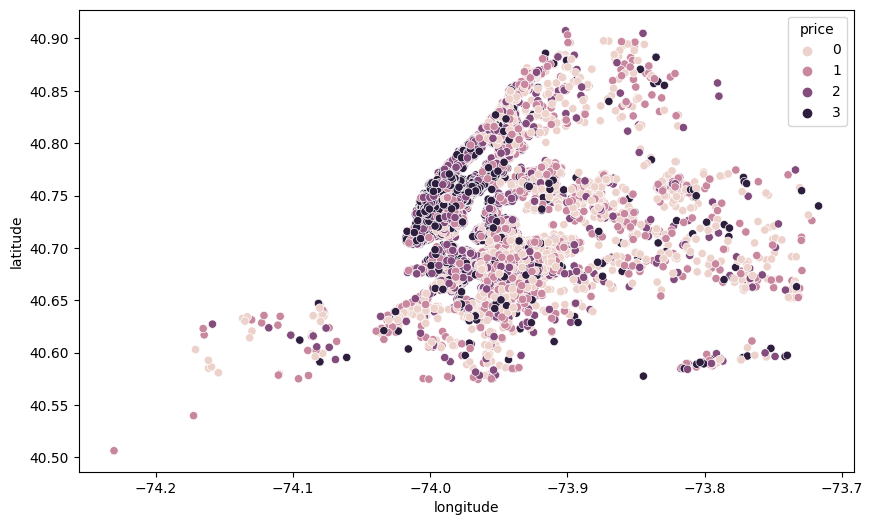

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_test.longitude, y=X_test.latitude, hue=y_test_clsf)
plt.ioff()
plt.show()

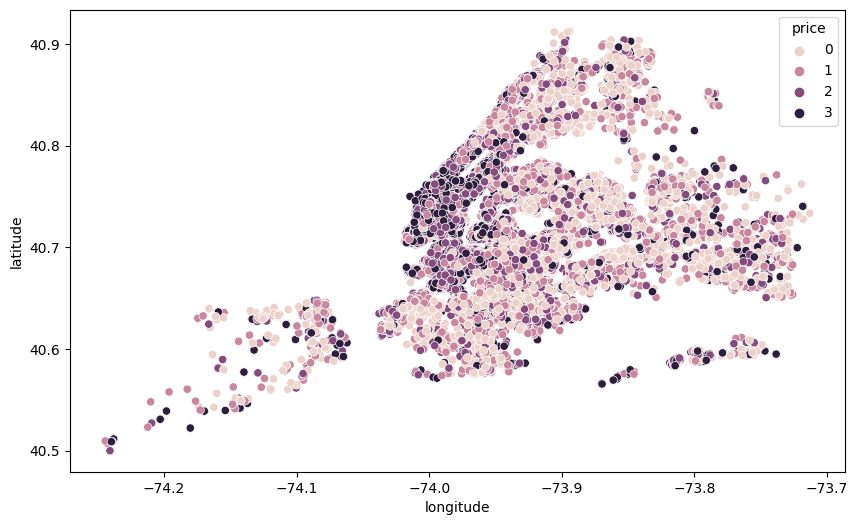

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_train.longitude, y=X_train.latitude, hue=y_train_clsf)
plt.ioff()
plt.show()

**The distribution of our classes is almost equal:**

In [52]:
y_train_clsf.value_counts()

0    9909
2    9793
3    9713
1    9701
Name: price, dtype: int64

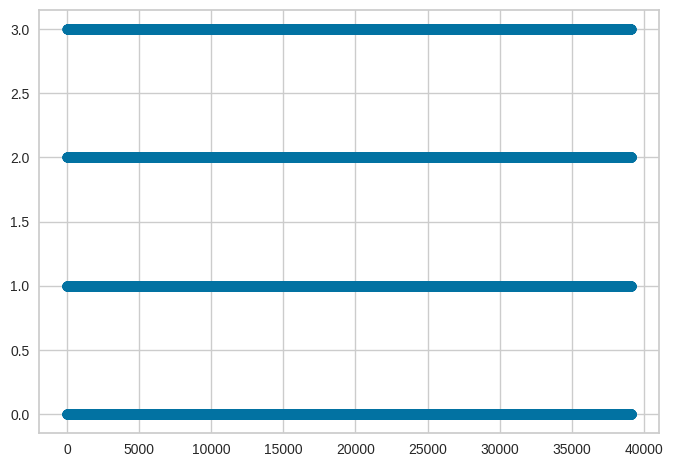

In [53]:
plt.scatter(range(len(y_train_clsf)),y_train_clsf)
plt.show()

In [ ]:
y_test_clsf.value_counts()

2    2488
3    2464
0    2462
1    2365
Name: price, dtype: int64

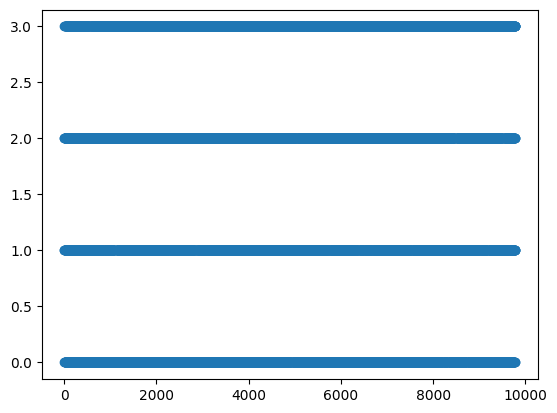

In [ ]:
plt.scatter(range(len(y_test_clsf)),y_test_clsf)
plt.show()

### Logistic Regression

In [58]:
model_all_data=LogisticRegression(multi_class="multinomial",max_iter=1000)
model_all_data.fit(X_train_comb,y_train_clsf)
print("Logistic Regression Model: ")
print("Train Accuracy:", model_all_data.score( X_train_comb, y_train_clsf))
print("Test Accuracy:",model_all_data.score( X_test_comb, y_test_clsf))

Logistic Regression Model: 
Train Accuracy: 0.522650577768688
Test Accuracy: 0.5296042540137028


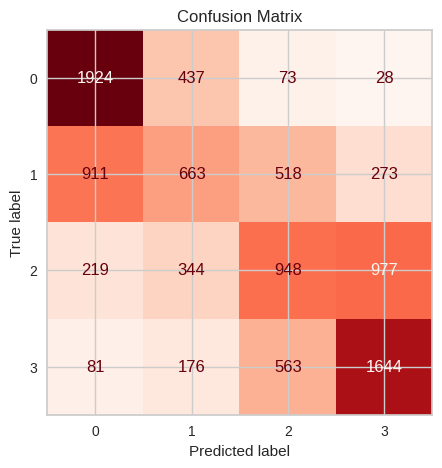

In [59]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 5))  # figsize parametresi ile grafiğin boyutunu ayarlayabilirsiniz

cm = ConfusionMatrixDisplay.from_estimator(model_all_data, X_test_comb, y_test_clsf, cmap="Reds", colorbar=False,ax=ax)
cm.ax_.set_title("Confusion Matrix")

plt.show()

### Gaussian NB

In [60]:
model_all_data = GaussianNB()
model_all_data.fit(X_train_comb, y_train_clsf)
print("Gaussian Naive Bayes Model")
print("Train Accuracy:", model_all_data.score(X_train_comb, y_train_clsf))
print("Test Accuracy:", model_all_data.score(X_train_comb, y_train_clsf))


Gaussian Naive Bayes Model
Train Accuracy: 0.49437570303712036
Test Accuracy: 0.49437570303712036


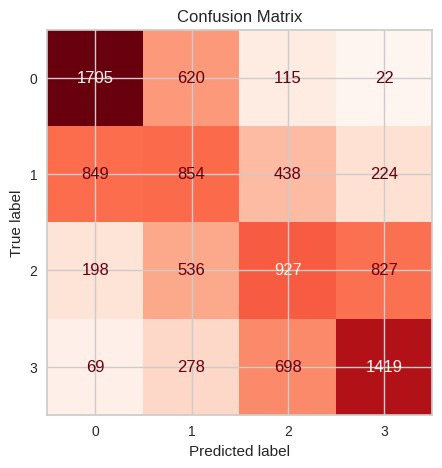

In [61]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 5))  # figsize parametresi ile grafiğin boyutunu ayarlayabilirsiniz

cm = ConfusionMatrixDisplay.from_estimator(model_all_data, X_test_comb, y_test_clsf, cmap="Reds", colorbar=False,ax=ax)
cm.ax_.set_title("Confusion Matrix")

plt.show()

### Support Vector Machine

In [56]:
model_all_data = SVC()
model_all_data.fit(X_train_comb, y_train_clsf)

train_score = model_all_data.score(X_train_comb, y_train_clsf)
test_score = model_all_data.score(X_test_comb, y_test_clsf)
print("SVM Model : ")
print("Train Accuracy:", train_score)
print("Test Accuracy:", test_score)


SVM Model : 
Train Accuracy: 0.5360721955210144
Test Accuracy: 0.5325697924123121


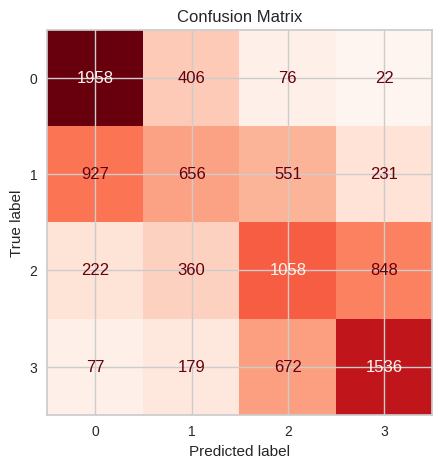

In [57]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 5))  

cm = ConfusionMatrixDisplay.from_estimator(model_all_data, X_test_comb, y_test_clsf, cmap="Reds", colorbar=False,ax=ax)
cm.ax_.set_title("Confusion Matrix")

plt.show()

### KNeighborsClassifier

In [64]:
from sklearn.neighbors import KNeighborsClassifier

model_all_data = KNeighborsClassifier()
model_all_data.fit(X_train_comb, y_train_clsf)
print("KNN Model:")
print("Train Accuracy:", model_all_data.score(X_train_comb, y_train_clsf))
print("Test Accuracy:", model_all_data.score(X_test_comb, y_test_clsf))


KNN Model:
Train Accuracy: 0.6282851007260456
Test Accuracy: 0.492279374169138


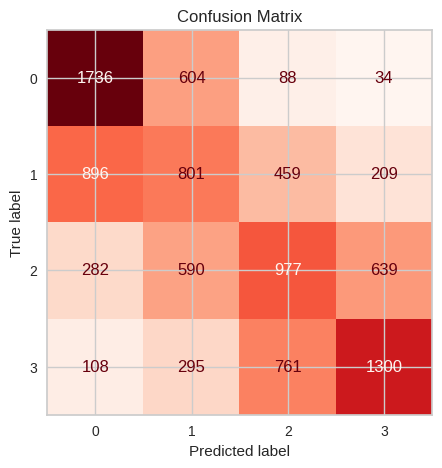

In [65]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 5))  

cm = ConfusionMatrixDisplay.from_estimator(model_all_data, X_test_comb, y_test_clsf, cmap="Reds", colorbar=False,ax=ax)
cm.ax_.set_title("Confusion Matrix")

plt.show()

### Decision Tree Classifier

In [66]:
from sklearn.tree import DecisionTreeClassifier

d_tree = DecisionTreeClassifier(criterion="gini", max_depth=4, random_state=1773)  #, #remove max_depth for illustration
d_tree.fit(X_train_comb, y_train_clsf)

DecisionTreeClassifier(max_depth=4, random_state=1773)

In [67]:
print(d_tree.classes_)

[0 1 2 3]


In [68]:
print("Decision Tree Classifier")
print("Train Accuracy: %.4f " % (d_tree.score(X_train_comb, y_train_clsf)))
print("Test Accuracy: %.4f " % (d_tree.score(X_test_comb, y_test_clsf)))

Decision Tree Classifier
Train Accuracy: 0.5243 
Test Accuracy: 0.5301 


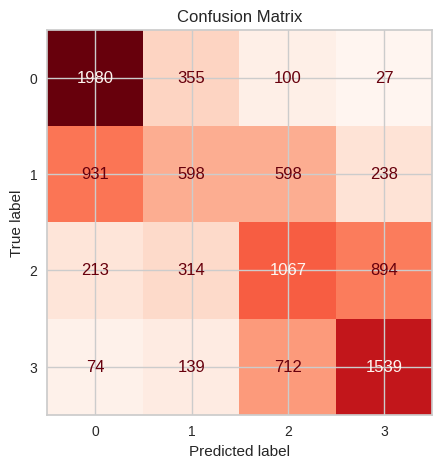

In [77]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 5))  

cm = ConfusionMatrixDisplay.from_estimator(d_tree, X_test_comb, y_test_clsf, cmap="Reds", colorbar=False,ax=ax)
cm.ax_.set_title("Confusion Matrix")

plt.show()

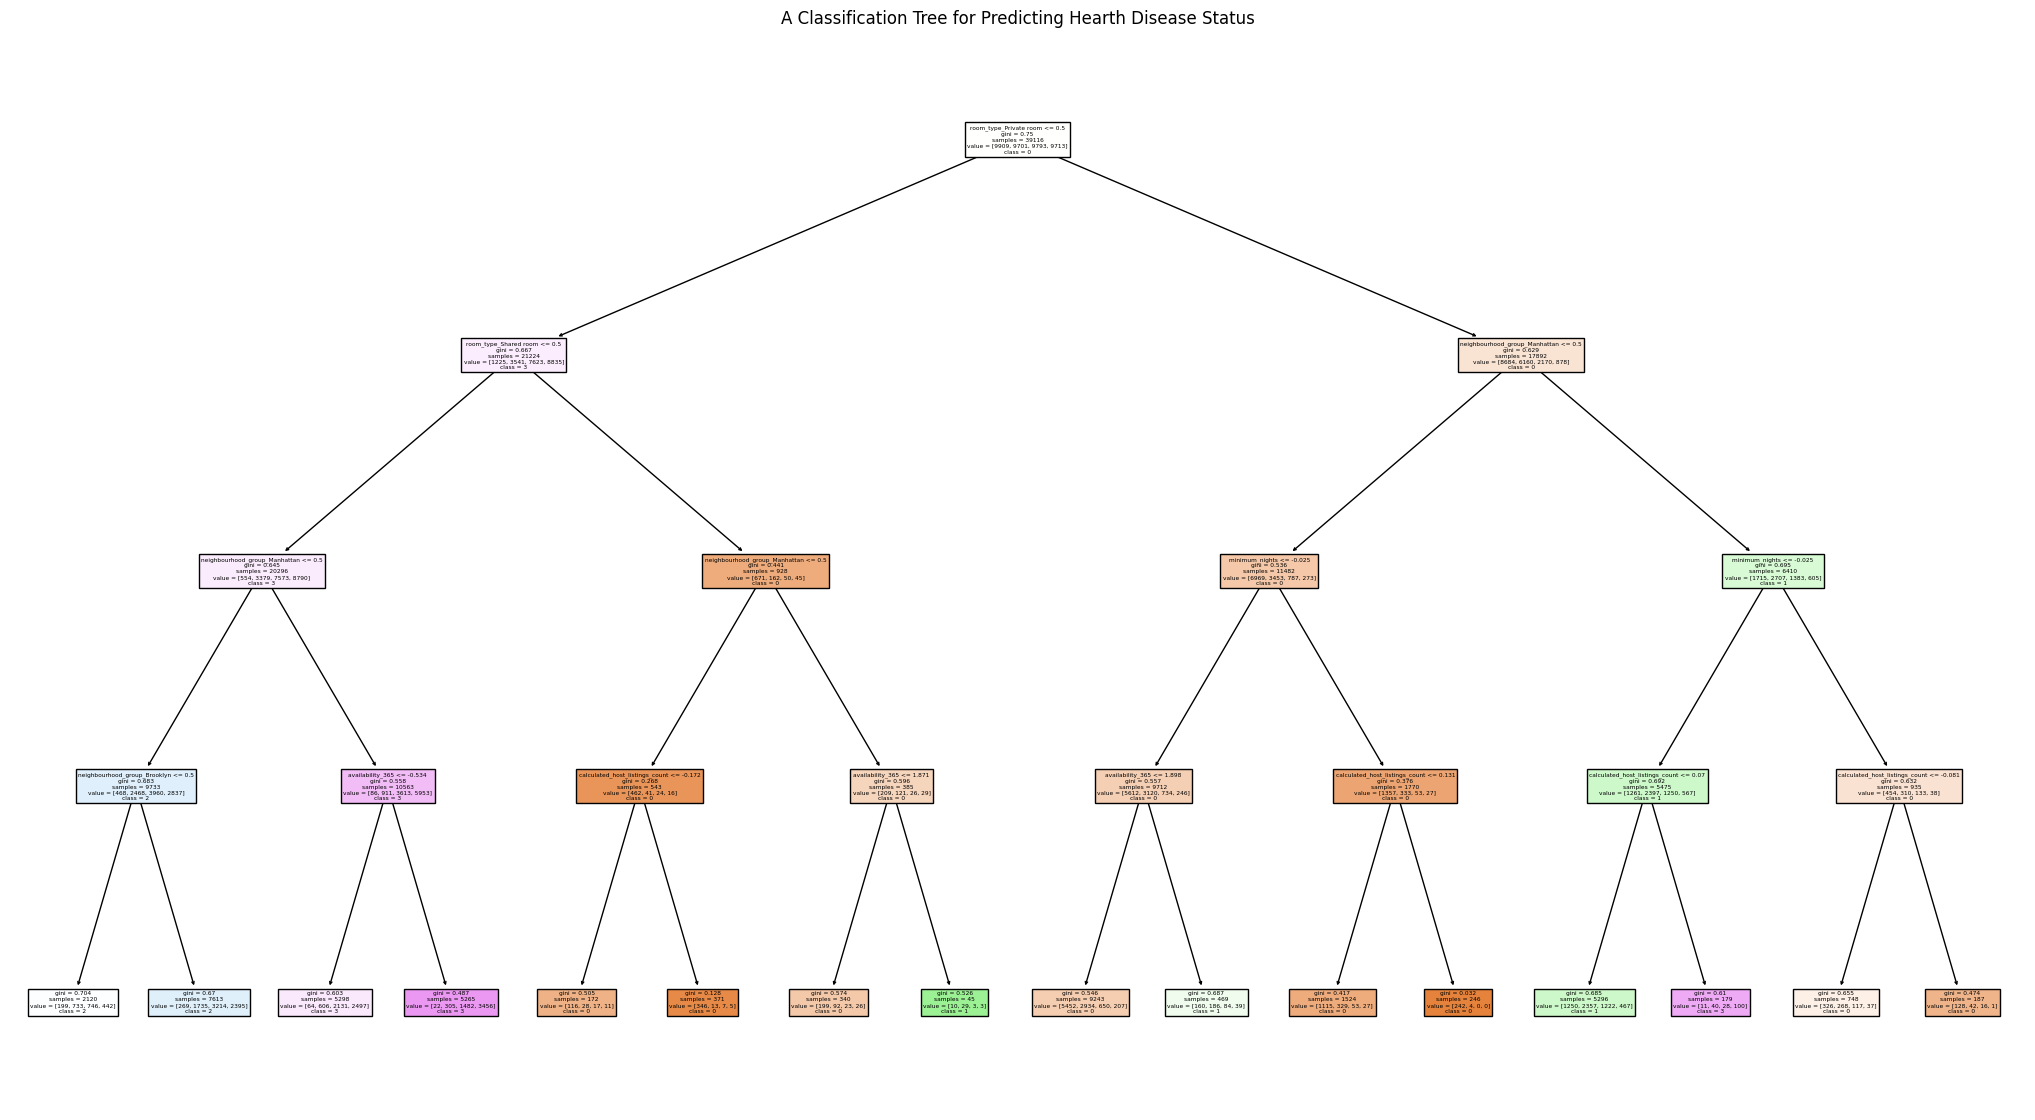

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [26, 14]

from sklearn.tree import plot_tree

fig, ax = plt.subplots()

tree_plot = plot_tree(d_tree, feature_names=X_train_comb.columns, class_names=["0","1","2","3"], impurity=True, ax=ax, filled=True)
plt.title("A Classification Tree for Predicting Hearth Disease Status")
plt.show();

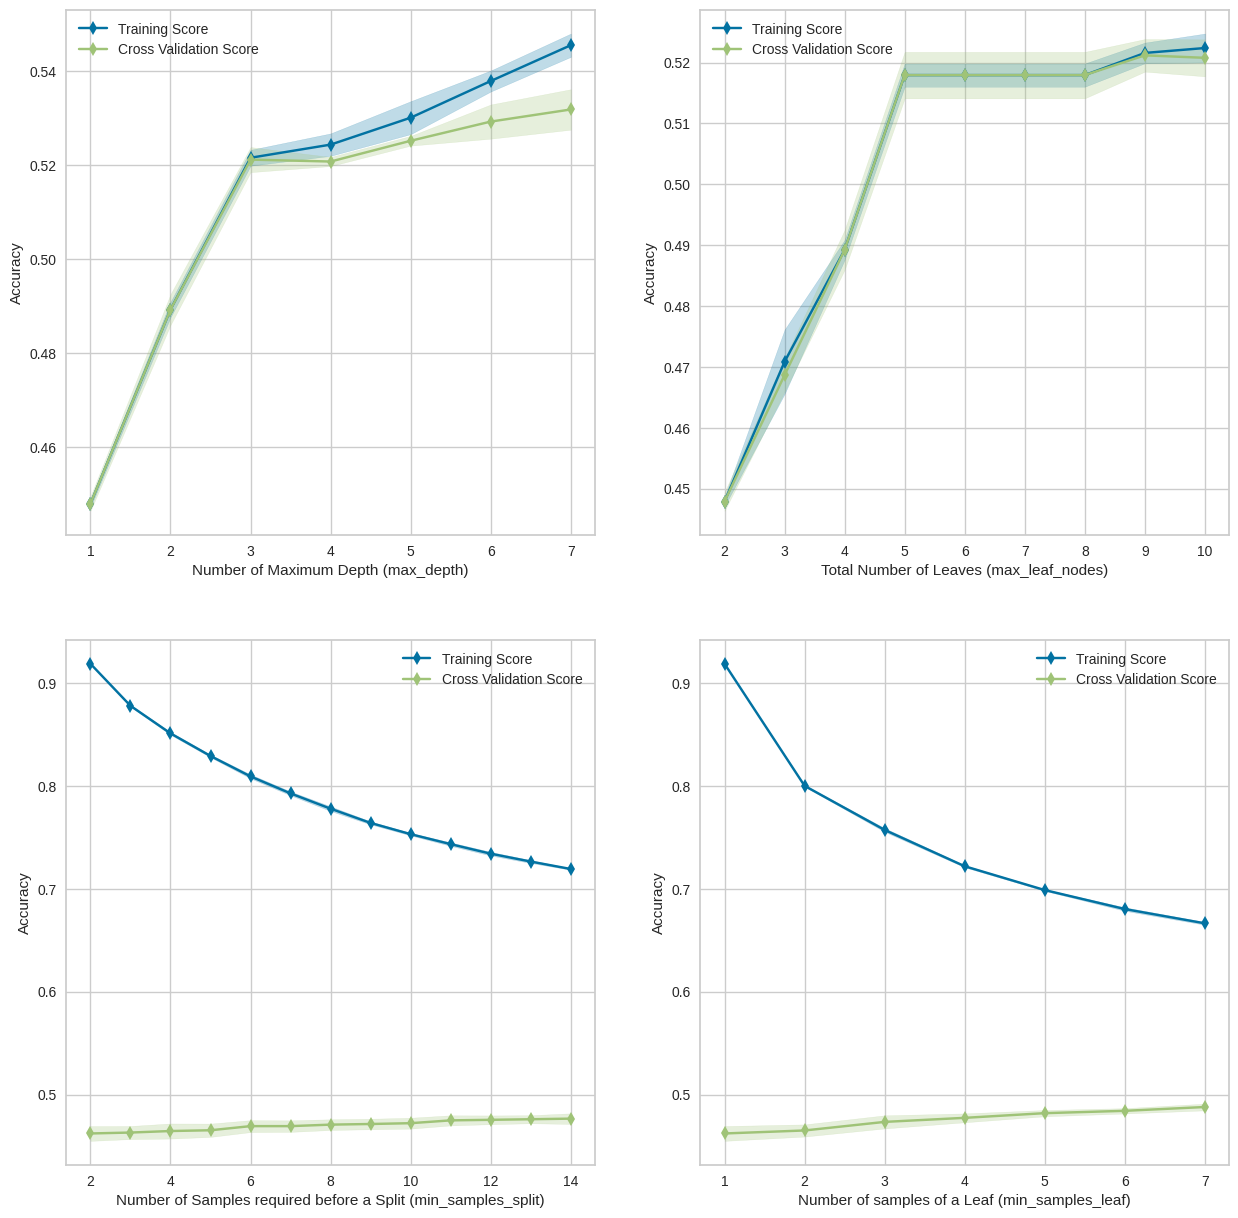

In [ ]:
#visualize results
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 15]

tree = DecisionTreeClassifier(random_state=1773)

kcv_index = StratifiedKFold(n_splits=3, shuffle=True, random_state=1773)    

param_names = ["max_depth", "max_leaf_nodes", "min_samples_split", "min_samples_leaf"] 

param_ranges = [list(range(1, 8)), list(range(2, 11)),list(range(2, 15)), list(range(1, 8))]   

title=["Number of Maximum Depth (max_depth)", 
       "Total Number of Leaves (max_leaf_nodes)", 
       "Number of Samples required before a Split (min_samples_split)",
       "Number of samples of a Leaf (min_samples_leaf)"]


## Create figure space

fig, axis = plt.subplots(2,2)

for i, ax in enumerate(axis.reshape(-1), 0):
    
    #print(i)
    
    # Initialize figure object
    visualizer = ValidationCurve(estimator = tree, 
                                 param_name = param_names[i],  
                                 param_range = param_ranges[i], 
                                 cv = kcv_index, 
                                 scoring = "accuracy", 
                                 ax = ax)

    # Visualize
    visualizer.fit(X_train_comb, y_train_clsf)
    visualizer.ax.set_ylabel("Accuracy")
    visualizer.ax.set_xlabel(title[i])
    visualizer.ax.legend().set_visible(True);
plt.show()

In [69]:
#multiple hyper-parameter tuning with RandomizedSearchCV

tree = DecisionTreeClassifier(random_state=1773)

#defining parameter range
param_grid = {'max_depth': list(range(1, 5)),
              'max_leaf_nodes': list(range(2, 6)),
              'min_samples_split': list(range(2, 5)),
               'min_samples_leaf': list(range(4, 8)),
              }

#The folds are made by preserving the percentage of samples for each class.
kcv_index = StratifiedKFold(n_splits=5, shuffle=True, random_state=1773) 

rd_search = RandomizedSearchCV(estimator = tree, 
                               param_distributions = param_grid,  #only this argument name is different
                               scoring='accuracy', 
                               cv = kcv_index,
                               random_state=1773) #randomized

In [70]:
rd_search.fit(X_train_comb, y_train_clsf)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1773, shuffle=True),
                   estimator=DecisionTreeClassifier(random_state=1773),
                   param_distributions={'max_depth': [1, 2, 3, 4],
                                        'max_leaf_nodes': [2, 3, 4, 5],
                                        'min_samples_leaf': [4, 5, 6, 7],
                                        'min_samples_split': [2, 3, 4]},
                   random_state=1773, scoring='accuracy')

In [71]:
rd_search.best_estimator_

DecisionTreeClassifier(max_depth=4, max_leaf_nodes=5, min_samples_leaf=6,
                       min_samples_split=3, random_state=1773)

In [72]:
print("Accuracy on train data after hiperparameter tunning: %.2f " % (rd_search.score(X_train_comb, y_train_clsf)*100))
print("Accuracy on test data  after hiperparameter tunnin: %.2f " % (rd_search.score(X_train_comb, y_train_clsf)*100))

Accuracy on train data after hiperparameter tunning: 51.79 
Accuracy on test data  after hiperparameter tunnin: 51.79 


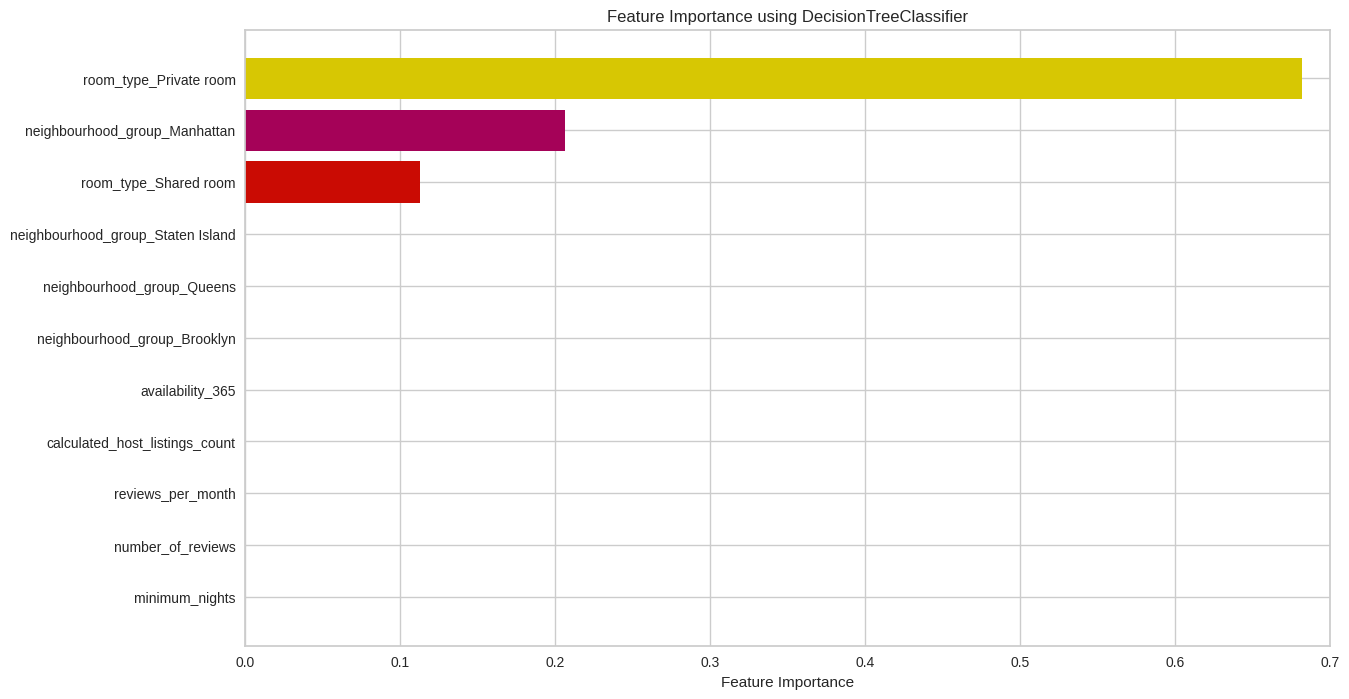

In [73]:
#visualize the importance of features
plt.rcParams['figure.figsize'] = [14, 8]

fig, ax = plt.subplots()

viz = FeatureImportances(rd_search.best_estimator_, relative=False, ax = ax) #
viz.fit(X_train_comb, y_train_clsf)
viz.ax.set_xlim((0,0.7))
viz.ax.set_title("Feature Importance using DecisionTreeClassifier")
viz.ax.set_xlabel("Feature Importance")
plt.show();

In [76]:
rf = RandomForestClassifier(n_estimators=50, criterion="gini", max_depth=3,  max_features='sqrt', random_state=1773)  #max_depth=3 for easiness
rf.fit(X_train_comb, y_train_clsf)
print(rf)
print("Accuracy on train data: %.2f " % (rf.score(X_train_comb, y_train_clsf)*100))
print("Accuracy on test data: %.2f" % (rf.score(X_train_comb, y_train_clsf)*100))

RandomForestClassifier(max_depth=3, n_estimators=50, random_state=1773)
Accuracy on train data: 51.77 
Accuracy on test data: 51.77


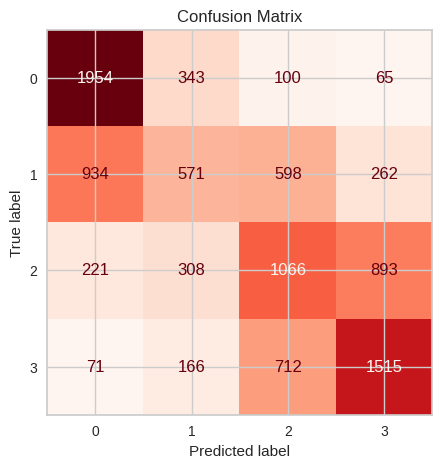

In [78]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 5))  

cm = ConfusionMatrixDisplay.from_estimator(rf, X_test_comb, y_test_clsf, cmap="Reds", colorbar=False,ax=ax)
cm.ax_.set_title("Confusion Matrix")

plt.show()

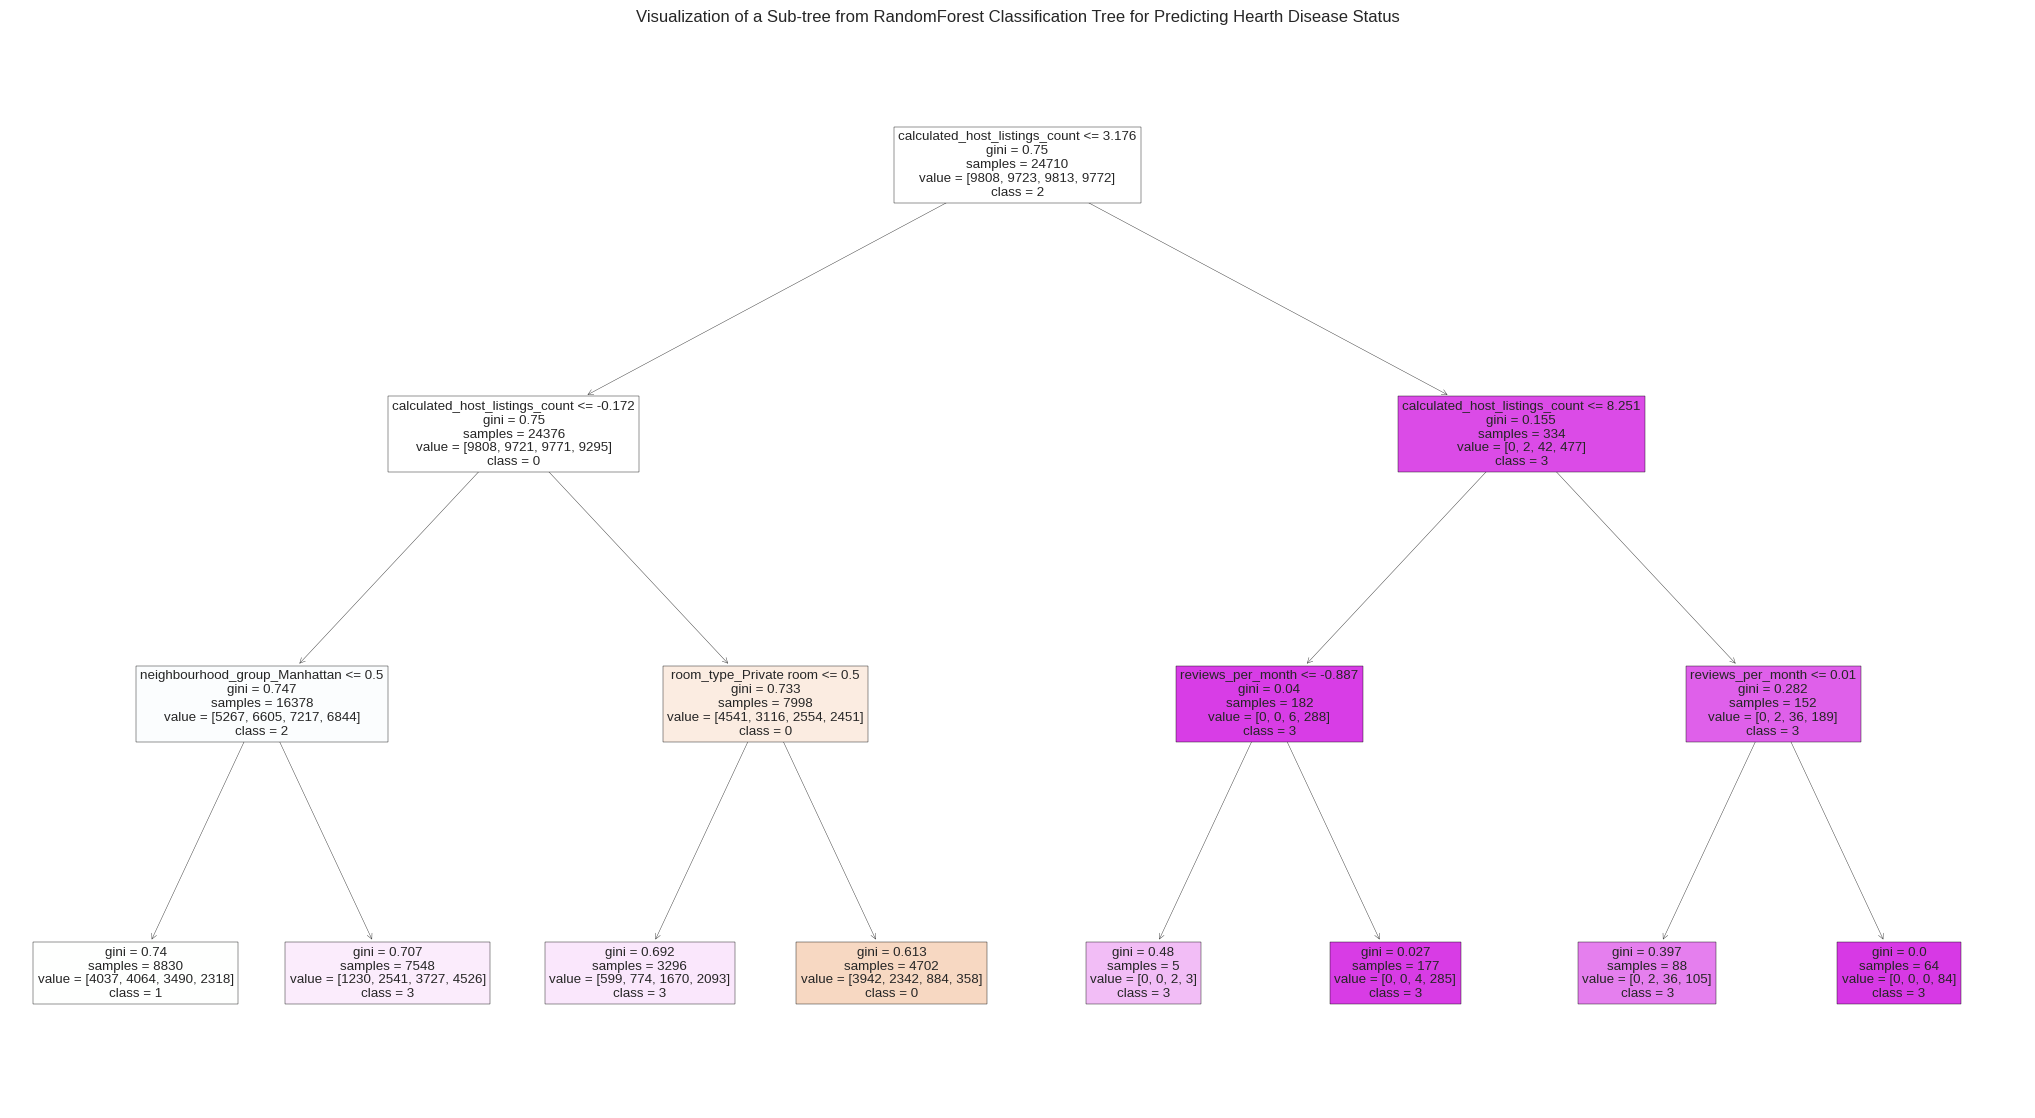

In [ ]:
#visualize the sub-tree
plt.rcParams['figure.figsize'] = [26, 14]


fig, ax = plt.subplots()

tree_plot = plot_tree(rf.estimators_[14], feature_names=X_train_comb.columns, class_names=["0","1","2","3"], impurity=True, ax=ax, filled=True)
plt.title("Visualization of a Sub-tree from RandomForest Classification Tree for Predicting Hearth Disease Status")
plt.show();
#her splitte 13 özellikten 3 tanesini seçip o üçlü arasındaki en güçlüsünü splitini yapıyor

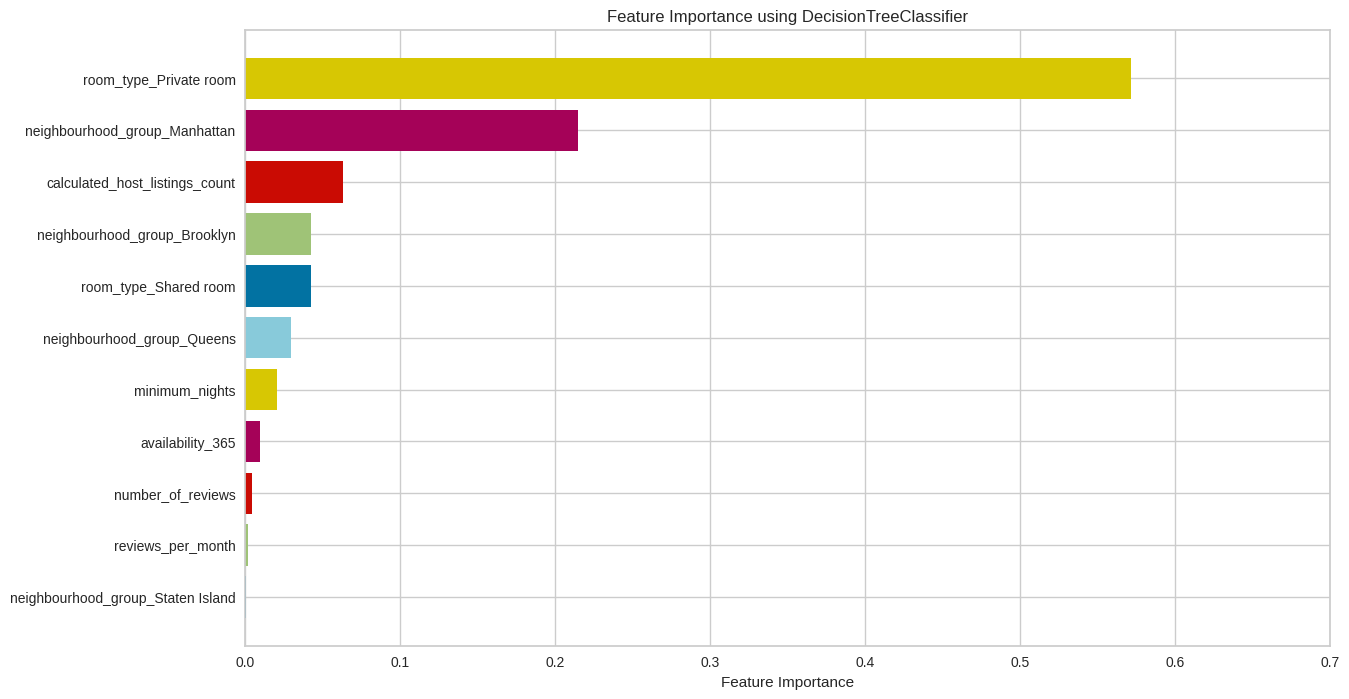

In [ ]:
#visualize the importance of features
plt.rcParams['figure.figsize'] = [14, 8]

fig, ax = plt.subplots()

viz = FeatureImportances(rf, relative=False, ax = ax) #
viz.fit(X_train_comb, y_train_clsf)
viz.ax.set_xlim((0,0.7))
viz.ax.set_title("Feature Importance using DecisionTreeClassifier")
viz.ax.set_xlabel("Feature Importance")
plt.show();

As we expected, randomsearch incorporates features further into the model.

## Clustering

---

In [24]:
X_train_clust=X_train_transformed[numeric_cols] 
X_test_clust=X_test_transformed[numeric_cols] 
X_test_clust.head()

,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
37564,2.418307,1.943607,-0.210612,0.060370,1.314539,-0.187282,1.795040
3660,-0.696762,-0.587723,-0.263565,-0.432973,-0.877204,-0.187282,-0.856544
35546,-1.218838,0.418485,-0.316517,-0.455398,0.231951,-0.035787,1.916602
5015,0.566613,0.930469,-0.210612,0.127644,-0.551764,-0.187282,-0.856544
584,-0.122900,-0.580143,-0.210612,2.661635,0.079193,-0.187282,0.404668


In [25]:
pca= PCA()
X_train_pca = pd.DataFrame(pca.fit_transform(X_test_clust))
#rename columns 
X_train_pca.columns = ["PC1", "PC2", "PC3", "PC4","PC5","PC6","PC7"]
X_train_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7
37564,-0.476907,2.028890,0.370863,-3.012054,-0.104475,-0.591356,-0.893770
3660,-0.091977,-1.355246,0.026075,0.798783,0.111791,0.102334,0.298801
35546,-0.120357,0.733460,-0.933865,0.147680,1.715890,-0.972860,-0.592122
5015,-0.371782,-0.449429,0.813668,-0.776514,-0.000094,0.556365,0.622387
584,-0.653552,1.633275,-0.005709,0.972754,-0.855712,-0.586842,1.612270


In [26]:
rotm = pd.DataFrame(pca.components_.T, 
                       index=numeric_cols, 
                       columns=['Load_vec1', 'Load_vec2',  'Load_vec3', 'Load_vec4',
                                'Load_vec5','Load_vec6','Load_vec7', ])                                                                             
rotm

,Load_vec1,Load_vec2,Load_vec3,Load_vec4,Load_vec5,Load_vec6,Load_vec7
latitude,0.019911,0.010294,0.116334,-0.733420,-0.658618,-0.116955,-0.024550
longitude,-0.122764,0.233651,0.352212,-0.549836,0.609107,0.340528,0.130354
minimum_nights,0.932127,0.199147,0.280886,0.080095,-0.021846,0.075246,0.005307
number_of_reviews,-0.192004,0.598949,0.115517,0.235619,-0.261605,-0.012861,0.683323
reviews_per_month,-0.185282,0.589228,0.080690,0.152748,-0.174307,0.270486,-0.696486
calculated_host_listings_count,0.174185,0.085355,-0.756952,-0.158314,-0.059720,0.582927,0.144788
availability_365,0.118895,0.438664,-0.436675,-0.222371,0.303886,-0.671988,-0.096902


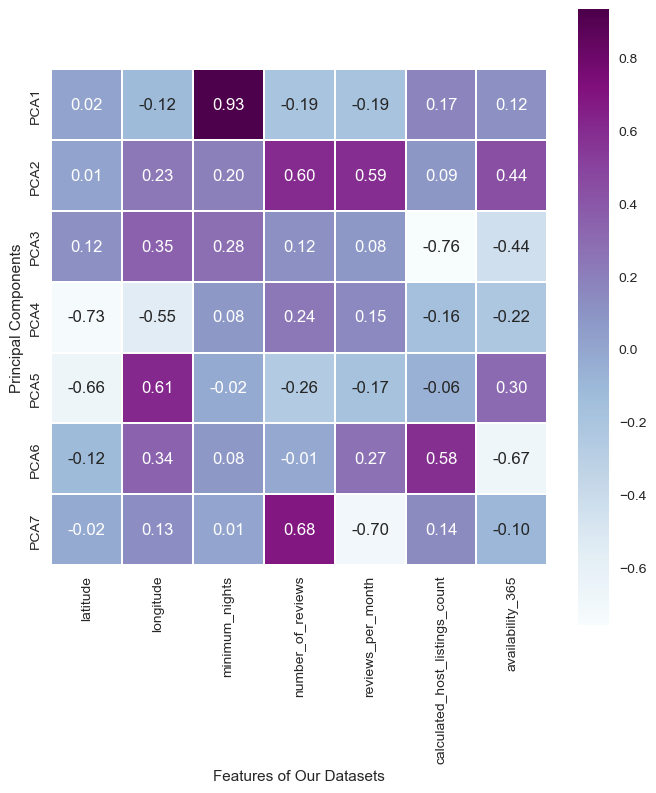

In [27]:
plt.rcParams['figure.figsize'] = [8,8]


# Feature Weight
sns.heatmap(pca.components_, cmap='BuPu',
                 yticklabels=["PCA"+str(x) for x in range(1,pca.n_components_+1)],
                 xticklabels=numeric_cols,
                 annot=True,
                 fmt='.2f',
                 square=True,
                 linewidths=0.05,
                 cbar_kws={"orientation": "vertical"})

plt.xlabel("Features of Our Datasets")
plt.ylabel("Principal Components")

plt.show()

In [28]:
numbr_of_columns=range(len(X_train_pca.columns)) 

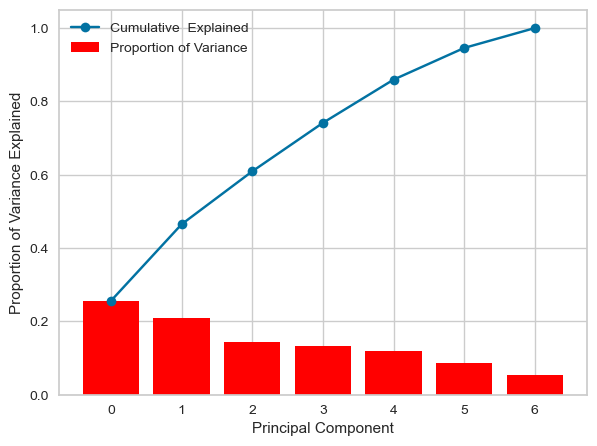

In [29]:
plt.rcParams['figure.figsize'] = [15, 5]

# Left-hand: Scree plot
plt.subplot(1, 2, 1)
plt.bar(numbr_of_columns, pca.explained_variance_ratio_, color="red",label='Proportion of Variance')
plt.plot(numbr_of_columns, np.cumsum(pca.explained_variance_ratio_), '-o', label='Cumulative  Explained')
plt.xlabel('Principal C')

plt.ylabel('Proportion of Variance Explained')
plt.xlabel('Principal Component')
plt.ylim(0,1.05)
plt.xticks(numbr_of_columns)
plt.legend(loc=2)

plt.show();

# Clustering

## K-Means Clustering

#### Elbow method to find optimal number of clusters 

In [30]:
inertia = []
K = range(1,11)

for k in K:
    km_k = KMeans(n_clusters=k, init='random', n_init=20, random_state=1773)
    km_k.fit(X_train_pca)
    inertia.append(km_k.inertia_)


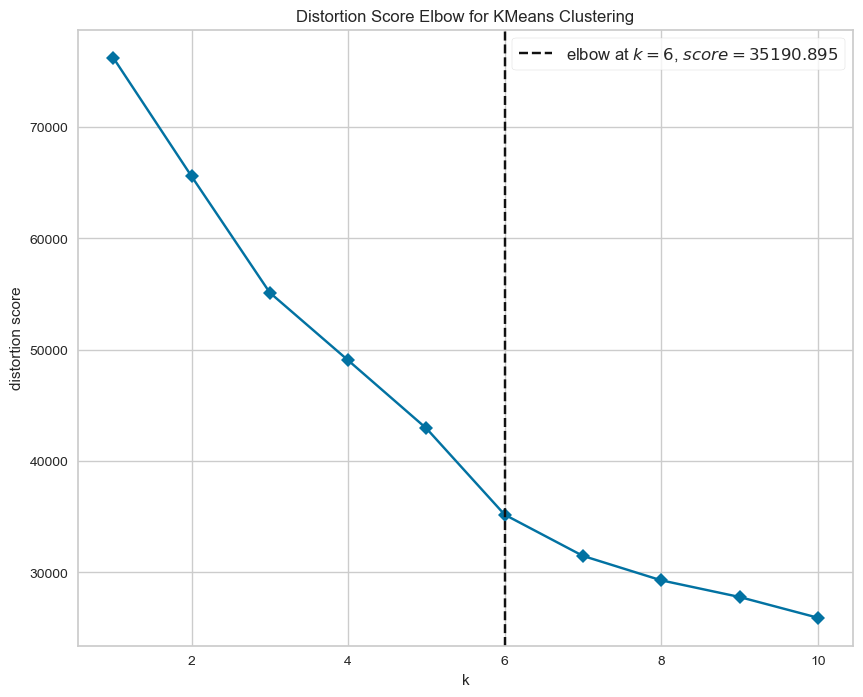

In [32]:
plt.rcParams['figure.figsize'] = [10, 8]

fig, ax = plt.subplots()

model = KMeans(n_clusters=k, init='random', n_init=20, random_state=1773)

visualizer = KElbowVisualizer(model, k=(1,11), timings=False, ax=ax)
visualizer.fit(X_train_pca)        # Fit the data to the visualizer
visualizer.ax.set_ylabel('Inertia')
visualizer.ax.set_title('The Elbow Method showing the optimal K');
visualizer.show();  

As seen in the elbow graph, the optimal number of clusters is observed as k 6. There is a stric change from 2 to 8.

In [34]:
tuned_clustering=KMeans(n_clusters=7,init='k-means++',random_state=0)
labels=tuned_clustering.fit_predict(X_train_clust) 
tuned_clustering.cluster_centers_[:]   # Return centroid coordinates of each cluster

array([[ 1.23696116e+00,  1.31937254e-01, -1.08371061e-01,
        -2.69742317e-01, -2.32604752e-01, -1.62230698e-01,
        -5.10116708e-01],
       [ 1.51602639e-02, -9.68435906e-01,  7.52005480e-01,
        -4.69946457e-01,  9.30498040e-02,  8.49890756e+00,
         1.27001929e+00],
       [-5.36392850e-01, -2.94326281e-01, -1.18695129e-01,
        -3.12409332e-01, -3.45097592e-01, -1.69459313e-01,
        -6.64815162e-01],
       [-7.26990091e-02, -2.48829001e-01,  3.60281376e-01,
        -1.97145745e-01, -1.82159807e-01,  1.46515913e-01,
         1.41711332e+00],
       [ 2.62595701e-03, -3.56119129e-01,  1.86952414e+01,
        -5.69592185e-02, -2.55518725e-01, -1.78625174e-01,
         8.29051402e-01],
       [-6.53817380e-02, -1.99708924e-02, -2.39482151e-01,
         2.06581833e+00,  1.82021829e+00, -1.56018714e-01,
         3.44229882e-01],
       [-2.60403046e-01,  2.68823510e+00, -2.10242118e-01,
        -9.22693331e-03,  3.94455857e-01, -1.26657536e-01,
         5.1474085

In [36]:
predictions =tuned_clustering.predict(X_test_clust)
silhouette_avg = silhouette_score(X_test_clust, predictions)
print("Silhouette Score:", silhouette_avg)

Silhouette Score: 0.25155051540988155


In [37]:
tuned_clustering.inertia_

117378.52534859581

The lesser the model inertia, the better the model fit. We can see that the model has very high inertia. So, this is not a good model fit to the data.


#### Visualization of Clusters

In [38]:
tuned_clustering.cluster_centers_  # Return cluster centers 

array([[ 1.23696116e+00,  1.31937254e-01, -1.08371061e-01,
        -2.69742317e-01, -2.32604752e-01, -1.62230698e-01,
        -5.10116708e-01],
       [ 1.51602639e-02, -9.68435906e-01,  7.52005480e-01,
        -4.69946457e-01,  9.30498040e-02,  8.49890756e+00,
         1.27001929e+00],
       [-5.36392850e-01, -2.94326281e-01, -1.18695129e-01,
        -3.12409332e-01, -3.45097592e-01, -1.69459313e-01,
        -6.64815162e-01],
       [-7.26990091e-02, -2.48829001e-01,  3.60281376e-01,
        -1.97145745e-01, -1.82159807e-01,  1.46515913e-01,
         1.41711332e+00],
       [ 2.62595701e-03, -3.56119129e-01,  1.86952414e+01,
        -5.69592185e-02, -2.55518725e-01, -1.78625174e-01,
         8.29051402e-01],
       [-6.53817380e-02, -1.99708924e-02, -2.39482151e-01,
         2.06581833e+00,  1.82021829e+00, -1.56018714e-01,
         3.44229882e-01],
       [-2.60403046e-01,  2.68823510e+00, -2.10242118e-01,
        -9.22693331e-03,  3.94455857e-01, -1.26657536e-01,
         5.1474085

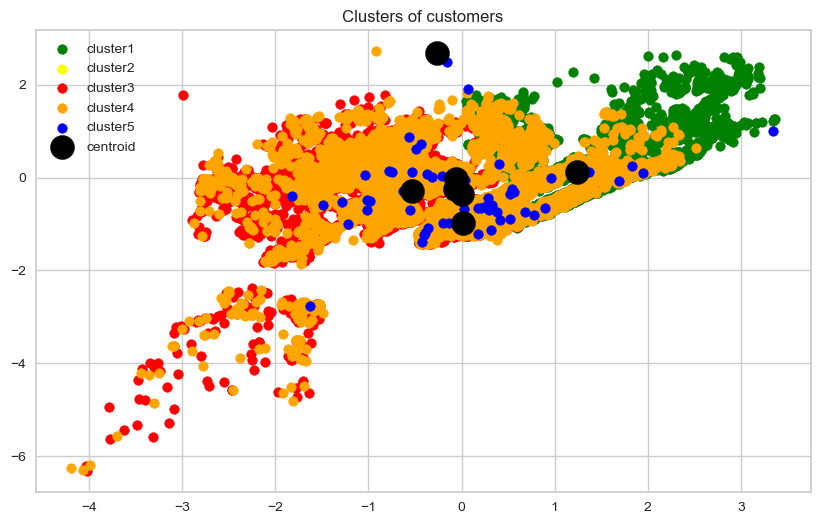

In [39]:
plt.figure(figsize=(10, 6))
plt.scatter(X_train_clust.iloc[labels==0,0],X_train_clust.iloc[labels==0,1],c='green',label='cluster1')
plt.scatter(X_train_clust.iloc[labels==1,0],X_train_clust.iloc[labels==1,1],c='yellow',label='cluster2')
plt.scatter(X_train_clust.iloc[labels==2,0],X_train_clust.iloc[labels==2,1],c='red',label='cluster3')
plt.scatter(X_train_clust.iloc[labels==3,0],X_train_clust.iloc[labels==3,1],c='orange',label='cluster4')
plt.scatter(X_train_clust.iloc[labels==4,0],X_train_clust.iloc[labels==4,1],c='blue',label='cluster5')
plt.scatter(tuned_clustering.cluster_centers_[:,0],tuned_clustering.cluster_centers_[:,1],s=300,c='black',label='centroid')
plt.title('Clusters of customers')
plt.legend()
plt.show()

In [40]:
metrics.silhouette_score(X_train_clust, tuned_clustering.labels_, metric='euclidean')

0.250965249615363

If our clustering is good then we have small intracluster distance then the Silhouette coefficient value is positive

If our clustering is bad then we have large intracluster distance then the Silhouette coefficient value is negative

Silhouette coefficient lies in between -1 and 1

If the value moves towards 1 then clustering is good

If the value moves towards < 0 then clustering is bad 

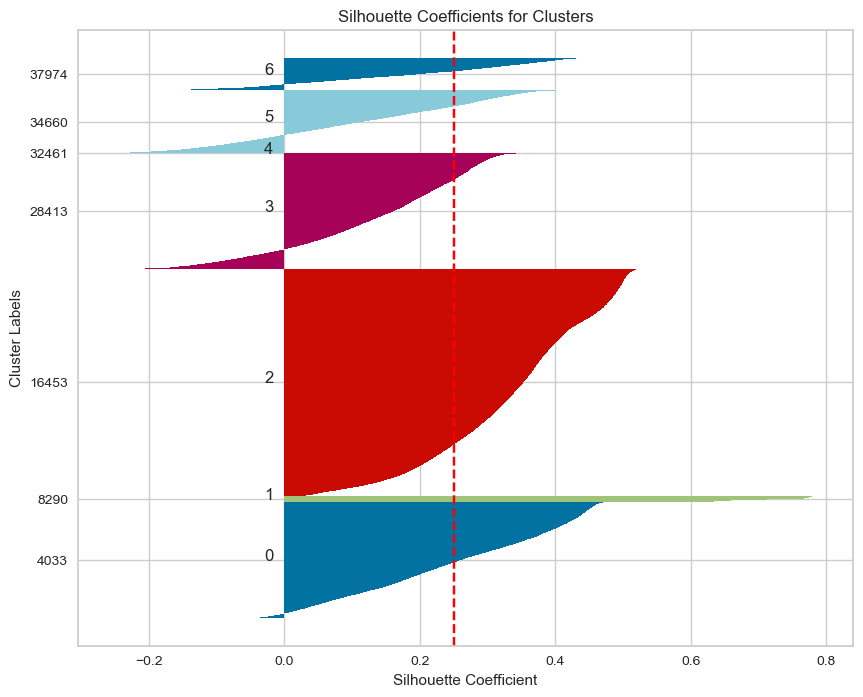

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_samples
silhouette_vals = silhouette_samples(X_train_clust, labels) # Calculate the Silhouette coefficient for each sample
sorted_vals = np.sort(silhouette_vals) # Sort the Silhouette coefficient values in ascending order
sorted_labels = labels[np.argsort(silhouette_vals)] # Get the cluster labels sorted by the Silhouette coefficient values
# Create a bar plot
fig, ax = plt.subplots()
y_ticks = []
y_lower = 0
for i, cluster_label in enumerate(np.unique(sorted_labels)):
    cluster_vals = sorted_vals[sorted_labels == cluster_label]
    cluster_size = len(cluster_vals)
    y_upper = y_lower + cluster_size
    ax.barh(range(y_lower, y_upper), cluster_vals, height=1.0, edgecolor='none')
    ax.text(-0.03, (y_lower + y_upper) / 2, str(cluster_label))
    y_ticks.append((y_lower + y_upper) / 2)
    y_lower = y_upper
ax.axvline(np.mean(sorted_vals), color="red", linestyle="--")  # Add a vertical line for the mean Silhouette coefficient
ax.set_yticks(y_ticks)
ax.set_ylabel('Cluster Labels')
ax.set_xlabel('Silhouette Coefficient')
ax.set_title('Silhouette Coefficients for Clusters')
plt.show()

##  Hierarchical Clustering 

### Dendogram 

In [ ]:
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(X_train_clust, method='ward'))

NameError: ignored

It would be a right choice to divide the data into 5 clusters, as it appears in different colors on the dendogram. We could also decide this by drawing a line around y=20 on the horizontal axis.

In [ ]:
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(X_train_clust, method='ward'))
plt.axhline(y=6, color='r', linestyle='--')

In [ ]:
from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')  
cluster.fit_predict(data_scaled)

## Conclusion 
Although our dataset did not give the accuracy values we expected,
we tried to increase the success rate by trying different models and
hyperparameter tunings.


For Regression: best model is GradientBoosting with Hyperparameter Tunning \
**Hyperparameter Tunning of Gradient Boosting Regression models: \
r2 Score of Train Data:  0.5227 \
r2 Score of Test Data:  0.5334**  \
For Classification: best model is Support Vector Machine (we can't any tunning, because ram is crashed) \
**SVM Models Accuracy Score \
Train Accuracy: 0.5361 \
Test Accuracy: 0.53256**


In [5]:
import session_info
session_info.show()